In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import colormaps
from pathlib import Path
from scipy.stats import shapiro, wilcoxon, binomtest
from sklearn.metrics import cohen_kappa_score

In [29]:
path_to_recist_measurements = Path("resources") / "recist_lesions_mapping.csv"
path_to_features_train = Path("resources") / "lesions_features_train.csv"
path_to_features_test = Path("resources") / "lesions_features_test.csv"
savefig = False
savecsv = False
save_title = False

## Comparison between RECIST and Automated measurements

In [3]:
def get_features_df(path_to_train_features, path_to_test_features):
    train_df = pd.read_csv(path_to_train_features)
    test_df = pd.read_csv(path_to_test_features)
    df = pd.concat([train_df, test_df])
    return df    

In [4]:
# Read data
recist_measurements_df = pd.read_csv(path_to_recist_measurements)
features_df = get_features_df(path_to_features_train, path_to_features_test)
features_df["label_value"] = features_df["label_value"].astype('int64')
target_measurements_df = recist_measurements_df.merge(
    features_df,
    left_on=['filename', 'lesion_label_value'],
    right_on=['filename', 'label_value'],
    how='inner'
)
display(target_measurements_df)

,subset,patient_id,uuid,study_uuid,study_date,series_name,filename,lesions_count,lesion_label_value,lesion_label_alias,...,label_value,label_description,voxels_count,volume_ml,slices_count,mean_HU,std_HU,major_axis,minor_axis,major_axis_slice_idx
0,entrenamiento,1,1.3.12.2.1107.5.1.4.83504.30000023042612315883...,1.3.51.0.1.1.172.19.3.128.3187796.3187735,20230426,Torax Cte 1.5 I70f 2,1.3.12.2.1107.5.1.4.83504.30000023042612315883...,2,1,A,...,1,"n,mediastinum",260256,131.541744,88,44.925972,92.982950,122.961314,70.113276,199
1,entrenamiento,1,1.3.12.2.1107.5.1.4.83504.30000023042612315883...,1.3.51.0.1.1.172.19.3.128.3187796.3187735,20230426,Torax Cte 1.5 I70f 2,1.3.12.2.1107.5.1.4.83504.30000023042612315883...,2,2,B,...,2,"t,lung",4840,2.446292,17,-4.722934,158.250810,24.193537,12.564874,291
2,entrenamiento,1,1.3.12.2.1107.5.1.4.83504.30000023042612315883...,1.3.51.0.1.1.172.19.3.128.3187796.3187735,20230426,Portal 5.0 I30f 1 iMAR,1.3.12.2.1107.5.1.4.83504.30000023042612315883...,1,1,C,...,1,"m,kidney",12334,20.160658,18,29.198233,31.280855,39.513884,26.968684,119
3,entrenamiento,2,1.3.12.2.1107.5.1.4.83504.30000022071212080050...,1.3.51.0.1.1.172.19.3.128.3051489.3051428,20220712,Portal 5.0 I30f 1,1.3.12.2.1107.5.1.4.83504.30000022071212080050...,2,1,B,...,1,"m,liver",5515,7.475294,9,79.737980,16.938963,28.045408,24.976645,155
4,entrenamiento,2,1.3.12.2.1107.5.1.4.83504.30000022071212080050...,1.3.51.0.1.1.172.19.3.128.3051489.3051428,20220712,Portal 5.0 I30f 1,1.3.12.2.1107.5.1.4.83504.30000022071212080050...,2,2,C,...,2,"m,liver",4656,6.310965,8,71.755370,22.166409,32.429782,18.906824,161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,test,3,1.3.12.2.1107.5.1.4.83504.30000021061509140333...,1.3.51.0.1.1.172.19.3.128.2857496.2857435,20210615,Portal 5.0 I30f 1,1.3.12.2.1107.5.1.4.83504.30000021061509140333...,3,3,A,...,3,"n,abdomen",119555,145.312931,37,70.704124,34.270943,148.007803,71.429434,112
57,test,3,1.3.12.2.1107.5.1.4.83504.30000021082509324422...,1.3.51.0.1.1.172.19.3.128.2890383.2890322,20210825,Portal 5.0 I30f 1,1.3.12.2.1107.5.1.4.83504.30000021082509324422...,4,2,C,...,2,"n,abdomen",6158,7.071291,11,49.106365,24.757280,29.877336,17.287778,92
58,test,3,1.3.12.2.1107.5.1.4.83504.30000021082509324422...,1.3.51.0.1.1.172.19.3.128.2890383.2890322,20210825,Portal 5.0 I30f 1,1.3.12.2.1107.5.1.4.83504.30000021082509324422...,4,1,B,...,1,"n,abdomen",15211,17.466939,37,51.013214,24.369925,23.724152,14.651937,98
59,test,3,1.3.12.2.1107.5.1.4.83504.30000021082509324422...,1.3.51.0.1.1.172.19.3.128.2890383.2890322,20210825,Portal 5.0 I30f 1,1.3.12.2.1107.5.1.4.83504.30000021082509324422...,4,5,A,...,5,"n,abdomen",101293,116.315735,37,55.024080,28.345240,123.900720,41.690296,124


In [5]:
# Clean recist measurements
recist_measurements_df = recist_measurements_df[recist_measurements_df["classification"] == "target"].copy()
recist_measurements_df["recist_measurement_mm"] = recist_measurements_df["recist_measurement_mm"].astype('float')

In [6]:
# Add diameter length to features dataframe
features_df["diameter_length"] = features_df.apply(lambda x: x["minor_axis"] if x["label_description"].split(',')[0] == 'n' else x['major_axis'], axis=1)
features_df["lesion_type"] = features_df["label_description"].apply(lambda x: x.split(',')[0])
features_df["lesion_location"] = features_df["label_description"].apply(lambda x: x.split(',')[1])

In [7]:
# Get dataframe with target measurements
target_measurements_df = recist_measurements_df.merge(
    features_df,
    left_on=['filename', 'lesion_label_value'],
    right_on=['filename', 'label_value'],
    how='inner'
)
target_measurements_df["lesion_type_label"] = target_measurements_df["lesion_type"].apply(lambda x: "tumor" if x in ["t", "m"] else "adenopathy")

In [8]:
target_measurements_df.describe()

,patient_id,study_date,lesions_count,lesion_label_value,recist_measurement_mm,label_value,voxels_count,volume_ml,slices_count,mean_HU,std_HU,major_axis,minor_axis,major_axis_slice_idx,diameter_length
count,61.000000,6.100000e+01,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,12.524590,2.021584e+07,17.606557,8.540984,36.639344,8.540984,38065.704918,35.735500,22.295082,46.611290,66.533619,51.458463,29.060286,137.114754,40.475803
std,8.219097,1.211060e+04,29.327052,21.663775,26.786833,21.663775,60199.192898,55.899359,18.414075,55.090317,74.222477,39.129702,19.326621,46.067378,28.786590
min,1.000000,2.019042e+07,1.000000,1.000000,5.000000,1.000000,356.000000,0.381013,3.000000,-220.438190,16.938963,9.842687,7.143322,38.000000,9.842687
25%,7.000000,2.021062e+07,4.000000,2.000000,17.000000,2.000000,5312.000000,4.663418,11.000000,46.161840,25.338367,27.894139,15.945229,113.000000,20.617114
50%,8.000000,2.021121e+07,8.000000,4.000000,28.000000,4.000000,9811.000000,11.118164,16.000000,59.096980,28.948431,35.309571,24.599310,128.000000,32.926017
75%,22.000000,2.023012e+07,12.000000,6.000000,40.000000,6.000000,50543.000000,42.737846,28.000000,74.942444,42.594257,69.548568,34.804475,161.000000,44.954360
max,25.000000,2.023091e+07,135.000000,142.000000,117.000000,142.000000,339746.000000,335.943453,88.000000,97.724390,276.359440,198.395296,93.200509,291.000000,145.453049


In [9]:
# Grouped by lesion label
grouped = target_measurements_df.groupby("label_description").size().reset_index(name="lesions_count")
display(grouped)
grouped = target_measurements_df.groupby("lesion_location").size().reset_index(name="lesions_count")
display(grouped)
grouped = target_measurements_df.groupby("lesion_type_label").size().reset_index(name="lesions_count")
display(grouped)

,label_description,lesions_count
0,"m,abdominal wall",4
1,"m,kidney",1
2,"m,liver",22
3,"m,lung",12
4,"n,abdomen",11
5,"n,aortocaval",1
6,"n,hepatic hilum",3
7,"n,iliac",1
8,"n,inguinal",1
9,"n,mediastinum",1


,lesion_location,lesions_count
0,abdomen,11
1,abdominal wall,4
2,aortocaval,1
3,hepatic hilum,3
4,iliac,1
5,inguinal,1
6,kidney,1
7,liver,22
8,lung,13
9,mediastinum,1


,lesion_type_label,lesions_count
0,adenopathy,21
1,tumor,40


In [10]:
# Difference = RECIST - Automated
target_measurements_df["measurement_difference"] = target_measurements_df["recist_measurement_mm"] - target_measurements_df["diameter_length"]
target_measurements_df["absolute_measurement_difference"] = target_measurements_df.apply(lambda x: np.abs(x["recist_measurement_mm"] - x["diameter_length"]), axis=1)

In [11]:
# Color mapping for lesion type labels
cmap = colormaps["tab10"]
unique_labels = target_measurements_df["lesion_type_label"].unique().tolist()
colors = [
    cmap(idx / (len(unique_labels) - 1))
    for idx in range(len(unique_labels))
]
colors = [
    cmap(7 / (len(unique_labels) + 20 - 1)),
    cmap(9 / (len(unique_labels) + 20 - 1))
]
first_color = colors.pop(0)
colors.insert(1, first_color)
color_mapping = {
    key: colors[idx]
    for idx, key in enumerate(unique_labels)
}

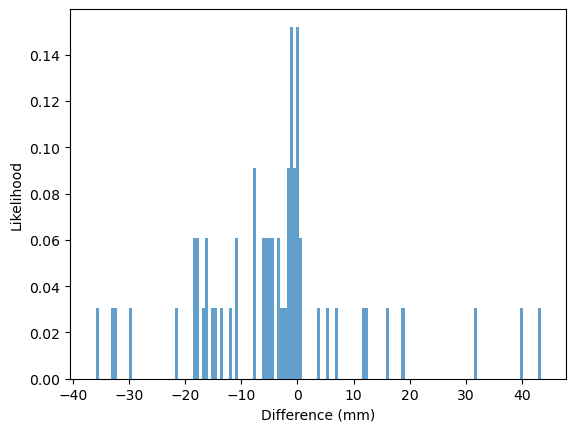

In [12]:
# Probability Distribution of Differences
bins = 150
bin_edges = np.linspace(
    target_measurements_df["measurement_difference"].min() - 1,
    target_measurements_df["measurement_difference"].max() + 1,
    bins
)
hist_values, _ = np.histogram(
    target_measurements_df["measurement_difference"],
    bins=bin_edges,
    density=True
)
plt.bar(
    bin_edges[:-1],
    hist_values,
    width=np.diff(bin_edges),
    alpha=0.7
)
plt.xlabel('Difference (mm)')
plt.ylabel('Likelihood')
plt.title('Distribution of Differences between RECIST and Automated Measurements')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'difference_distribution_target_measurements.png', bbox_inches='tight', transparent=True)
plt.show()

In [13]:
# Test normality
stat, p = shapiro(target_measurements_df["measurement_difference"])
if p > 0.05:
    print("Differences follow a normal distribution (p =", p, ")")
else:
    print("Differences do NOT follow a normal distribution (p =", p, ")")

Differences do NOT follow a normal distribution (p = 0.0002029825193281472 )


In [14]:
# Testing difference (distribution of differences symmetric about zero)
stat, p = wilcoxon(target_measurements_df["measurement_difference"])
if p > 0.05:
    print("There's no enough evidence supporting differences are statistically significant (p =", p, ")")
else:
    print("Differences are statistically signicant (p =", p, ")")
print("Wilcoxon test p-value:", p)

Differences are statistically signicant (p = 0.000940761999438391 )
Wilcoxon test p-value: 0.000940761999438391


In [15]:
target_measurements_df[['measurement_difference', 'absolute_measurement_difference']].describe()

,measurement_difference,absolute_measurement_difference
count,61.000000,61.000000
mean,-3.836458,10.200135
std,14.564323,11.013919
min,-35.177123,0.051930
25%,-11.875308,1.260008
50%,-2.966563,5.503424
75%,0.197348,16.074407
max,43.116197,43.116197


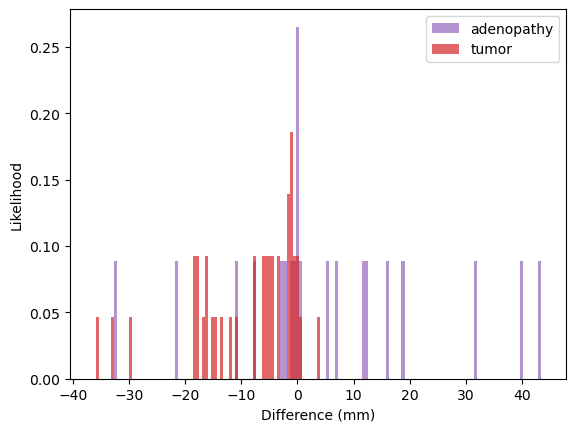

In [16]:
# Probability Distribution of Differences grouped by lesion type (tumor vs adenopathy)
bins = 150
bin_edges = np.linspace(
    target_measurements_df["measurement_difference"].min() - 1,
    target_measurements_df["measurement_difference"].max() + 1,
    bins
)
for label in target_measurements_df["lesion_type_label"].unique().tolist():

    hist_values, _ = np.histogram(
        target_measurements_df[target_measurements_df["lesion_type_label"] == label]["measurement_difference"],
        bins=bin_edges,
        density=True
    )
    plt.bar(
        bin_edges[:-1],
        hist_values,
        width=np.diff(bin_edges),
        alpha=0.7,
        label=label,
        color=color_mapping[label]
    )
plt.xlabel('Difference (mm)')
plt.ylabel('Likelihood')
plt.title('Distribution of Differences between RECIST and Automated Measurements')
plt.legend()
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'difference_distribution_target_measurements_grouped.png', bbox_inches='tight', transparent=True)
plt.show()

In [17]:
# Save dataframes
if savecsv:
    target_measurements_df.to_csv(Path.cwd() / "results" / "target_measurements.csv", index=False)

In [18]:
target_measurements_df.groupby('lesion_type_label').describe()[["measurement_difference", "absolute_measurement_difference"]]

measurement_difference                                  \
                                   count      mean        std        min   
lesion_type_label                                                          
adenopathy                          21.0  5.312376  18.152265 -32.399011   
tumor                               40.0 -8.639596   9.414316 -35.177123   

                                                              \
                         25%       50%        75%        max   
lesion_type_label                                              
adenopathy         -1.809927  0.348063  12.711724  43.116197   
tumor             -15.327025 -5.357557  -1.206358   4.113250   

                  absolute_measurement_difference                        \
                                            count       mean        std   
lesion_type_label                                                         
adenopathy                                   21.0  12.679294  13.796174   
tumor                                        40.0   8.898576   9.163561   

                                                                       
                        min       25%       50%        75%        max  
lesion_type_label                                                      
adenopathy         0.051930  1.097288  7.599310  19.309704  43.116197  
tumor              0.193537  1.434193  5.357557  15.327025  35.177123

In [19]:
# Test for differences grouped by lesion type
for lesion in target_measurements_df["lesion_type_label"].unique().tolist():
    stat, p = wilcoxon(target_measurements_df[target_measurements_df["lesion_type_label"] == lesion]["measurement_difference"])
    print(f"Testing for {lesion}")
    print(30 * '-')
    if p > 0.05:
        print("There's no enough evidence supporting differences are statistically significant (p =", p, ")")
    else:
        print("Differences are statistically signicant (p =", p, ")")
    print("Wilcoxon test p-value:", p)
    print('\n')

Testing for adenopathy
------------------------------
There's no enough evidence supporting differences are statistically significant (p = 0.27221012115478516 )
Wilcoxon test p-value: 0.27221012115478516


Testing for tumor
------------------------------
Differences are statistically signicant (p = 2.293745637871325e-09 )
Wilcoxon test p-value: 2.293745637871325e-09




In [20]:
target_measurements_df["measurement_difference"].shape

(61,)

In [21]:
# Testing under/over estimation grouped by type of lesion
for lesion in target_measurements_df["lesion_type_label"].unique().tolist():
    num_positive = target_measurements_df[
    (target_measurements_df["lesion_type_label"] == lesion) &
    (target_measurements_df["measurement_difference"] > 0)
    ].size
    num_total = target_measurements_df[
    target_measurements_df["lesion_type_label"] == lesion
    ].size
    over_result = binomtest(
        num_positive,
        num_total,
        p=0.5,
        alternative='greater'
    )
    under_result = binomtest(
        num_positive,
        num_total,
        p=0.5,
        alternative='less'
    )
    print(f"Testing for {lesion}")
    print(30 * '-')
    print("Overestimation:")
    if over_result.pvalue < 0.05:
        print(f"RECIST measurements systematically overestimates automated measurements (p = {over_result.pvalue})")
    else:
        print(f"No significant systematic trend is found (p = {over_result.pvalue}).")
    print("\nUnderestimation:")
    if under_result.pvalue < 0.05:
        print(f"RECIST measurements systematically underestimates automated measurements (p = {under_result.pvalue})")
    else:
        print(f"No significant systematic trend is found (p = {under_result.pvalue}).")
    print('\n')

Testing for adenopathy
------------------------------
Overestimation:
RECIST measurements systematically overestimates automated measurements (p = 4.238640072649887e-09)

Underestimation:
No significant systematic trend is found (p = 0.99999999742667).


Testing for tumor
------------------------------
Overestimation:
No significant systematic trend is found (p = 1.0).

Underestimation:
RECIST measurements systematically underestimates automated measurements (p = 4.167160709591147e-181)




## RECIST classification

In [22]:
tumoral_burden_df = target_measurements_df.groupby(["patient_id", "study_date"])["recist_measurement_mm"].sum().reset_index(name="recist_tumoral_burden")
tumoral_burden_df["automated_tumoral_burden"] = target_measurements_df.groupby(["patient_id", "study_date"])["diameter_length"].sum().reset_index(name="automotated_tumoral_burden")["automotated_tumoral_burden"]
display(tumoral_burden_df)

,patient_id,study_date,recist_tumoral_burden,automated_tumoral_burden
0,1,20230426,146.0,133.820696
1,2,20220712,49.0,60.475190
2,3,20210615,101.0,105.471951
3,3,20210825,93.0,73.630011
4,3,20211027,61.0,82.463946
5,5,20210527,28.0,31.066164
6,7,20210526,57.0,58.118349
7,7,20210802,57.0,63.860702
8,7,20211007,72.0,81.027460
9,8,20220825,40.0,95.551270


In [23]:
output_classes = []
study_dates = tumoral_burden_df.groupby(["patient_id"])["study_date"].size().reset_index(name="date_counts")
cleaned_study_dates = study_dates[study_dates["date_counts"] > 1]
subset_df = tumoral_burden_df[tumoral_burden_df["patient_id"].isin(cleaned_study_dates["patient_id"].unique().tolist())].copy()
subset_df.sort_values(by=["patient_id", "study_date"], inplace=True)
display(subset_df)

,patient_id,study_date,recist_tumoral_burden,automated_tumoral_burden
2,3,20210615,101.0,105.471951
3,3,20210825,93.0,73.630011
4,3,20211027,61.0,82.463946
6,7,20210526,57.0,58.118349
7,7,20210802,57.0,63.860702
8,7,20211007,72.0,81.027460
9,8,20220825,40.0,95.551270
10,8,20221012,80.0,84.709170
11,8,20221129,71.0,70.432769
12,8,20230117,57.0,65.926708


In [24]:
classifications = []
for patient_id in subset_df["patient_id"].unique().tolist():
    studies_subset_df = subset_df[subset_df["patient_id"] == patient_id]
    difference_df = subset_df[subset_df["patient_id"] == patient_id].diff()
    difference_df.dropna(inplace=True)
    difference_df["patient_id"] = subset_df[subset_df["patient_id"] == patient_id]["patient_id"].iloc[1:]
    difference_df["study_date"] = subset_df[subset_df["patient_id"] == patient_id]["study_date"].iloc[1:]
    # Set initial values
    recist_baseline_date = studies_subset_df["study_date"].iloc[0]
    recist_min_burden = studies_subset_df["recist_tumoral_burden"].iloc[0]
    automated_baseline_date = studies_subset_df["study_date"].iloc[0]
    automated_min_burden = studies_subset_df["automated_tumoral_burden"].iloc[0]
    for idx, (_, row) in enumerate(difference_df.iterrows()):
        # RECIST
        recist_current_burden = studies_subset_df["recist_tumoral_burden"].iloc[idx+1]
        recist_percentual_variation = 100 * (recist_current_burden - recist_min_burden) / recist_min_burden
        if recist_percentual_variation < -30.0:
            recist_classification = "PR"
        elif recist_percentual_variation > 20.0:
            recist_classification = "PD"
        else:
            recist_classification = "SD"
        # Automated
        automated_current_burden = studies_subset_df["automated_tumoral_burden"].iloc[idx+1]
        automated_percentual_variation = 100 * (automated_current_burden - automated_min_burden) / automated_min_burden
        if automated_percentual_variation < -30.0:
            automated_classification = "PR"
        elif automated_percentual_variation > 20.0:
            automated_classification = "PD"
        else:
            automated_classification = "SD"
        classifications.append({
            "patient_id": patient_id,
            "current_date": str(int(row["study_date"])),
            "recist_baseline_date": recist_baseline_date,
            "recist_current_burden": recist_current_burden,
            "recist_baseline_burden": recist_min_burden,
            "recist_burden_difference": recist_current_burden - recist_min_burden,
            "recist_burden_percentual_variation": recist_percentual_variation,
            "recist_classification": recist_classification,
            "automated_baseline_date": automated_baseline_date,
            "automated_current_burden": automated_current_burden,
            "automated_baseline_burden": automated_min_burden,
            "automated_burden_difference": automated_current_burden - automated_min_burden,
            "automated_burden_percentual_variation": automated_percentual_variation,
            "automated_classification": automated_classification
        })
        if recist_current_burden < recist_min_burden:
            recist_min_burden = recist_current_burden
            recist_baseline_date = studies_subset_df["study_date"].iloc[idx+1]

classifications_df = pd.DataFrame(classifications)
display(classifications_df)

,patient_id,current_date,recist_baseline_date,recist_current_burden,recist_baseline_burden,recist_burden_difference,recist_burden_percentual_variation,recist_classification,automated_baseline_date,automated_current_burden,automated_baseline_burden,automated_burden_difference,automated_burden_percentual_variation,automated_classification
0,3,20210825,20210615,93.0,101.0,-8.0,-7.920792,SD,20210615,73.630011,105.471951,-31.841941,-30.189961,PR
1,3,20211027,20210825,61.0,93.0,-32.0,-34.408602,PR,20210615,82.463946,105.471951,-23.008005,-21.814335,SD
2,7,20210802,20210526,57.0,57.0,0.0,0.000000,SD,20210526,63.860702,58.118349,5.742353,9.880447,SD
3,7,20211007,20210526,72.0,57.0,15.0,26.315789,PD,20210526,81.027460,58.118349,22.909111,39.418034,PD
4,8,20221012,20220825,80.0,40.0,40.0,100.000000,PD,20220825,84.709170,95.551270,-10.842100,-11.346893,SD
5,8,20221129,20220825,71.0,40.0,31.0,77.500000,PD,20220825,70.432769,95.551270,-25.118501,-26.287982,SD
6,8,20230117,20220825,57.0,40.0,17.0,42.500000,PD,20220825,65.926708,95.551270,-29.624562,-31.003839,PR
7,12,20190703,20190415,38.0,36.0,2.0,5.555556,SD,20190415,43.039792,42.010005,1.029787,2.451289,SD
8,12,20191030,20190415,38.0,36.0,2.0,5.555556,SD,20190415,62.742484,42.010005,20.732479,49.351288,PD
9,16,20230808,20230612,67.0,79.0,-12.0,-15.189873,SD,20230612,107.680547,96.491540,11.189007,11.595843,SD


In [25]:
classifications_df[["recist_classification", "automated_classification"]]

,recist_classification,automated_classification
0,SD,PR
1,PR,SD
2,SD,SD
3,PD,PD
4,PD,SD
5,PD,SD
6,PD,PR
7,SD,SD
8,SD,PD
9,SD,SD


In [26]:
classifications_kappa = cohen_kappa_score(
    classifications_df["recist_classification"],
    classifications_df["automated_classification"]
)
print(f"Cohen's Kappa agreement between Manual RECIST and Automated classification: {classifications_kappa}")

Cohen's Kappa agreement between Manual RECIST and Automated classification: 0.09160305343511455


In [27]:
classifications_df[classifications_df["recist_classification"] == classifications_df["automated_classification"]].shape

(10, 14)

In [28]:
if savecsv:
    classifications_df.to_csv(
        Path.cwd() / "results" / "recist_and_automated_classifications.csv",
        index=False
    )

## Highlights
- Total of RECIST measurements: 61.
- Difference between manual RECIST and automated measurements **are statiscally significant**, meaning the distribution of differences is not symmetric about zero (p =  9.4e-4, Wilcoxon signed-rank test). **Observed Mean is **-3.8 +- 14.6** with a Median equal to **-3.0**.
- RECIST measurements of tumoral lesions tends to underestimate automated diameter length (p = 4.167160709591147e-181, signed-rank test, 40 lesions).
- RECIST measurements of adenopathies tends to overestimate automated diameter length (p = 4.238640072649887e-09, signed-rank test, 21 lesions).
- From the whole set of RECIST measurements, 17 tumor burden assessments (comparisons to baseline) were obtained. **In only 10/17 (58.8%) classifications manual RECIST and automated approach resulted in the same response** (Progressive Disease, Partial Responde, or Stable Disease). **The agreement between both measurements is just slight** (Cohen's Kappa k=0.09).
- Observations:
    - The difference between manual RECIST and automated measurements is statiscally significant. However, are small differences a neccessary condition to reach agreement in RECIST classifications? I'd say it's sufficient, but not required.
  